# Augmenting data for neural network training

In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.style.use('science')

from astropy.io import fits
from astropy.table import Table, vstack
import pandas as pd
from matplotlib import colors

import warnings
from torch import Tensor
import pandas as pd
import pickle

Here we have a sample table of observed stars, with known ages and Av. We want to vastly increase the size of this sample.

In [2]:
final2 = fits.open('Data/Train/final2.fits')
trData = Table(final2[1].data)
np.random.seed(0); trData = trData[np.random.permutation(len(trData))]#.to_pandas()
#Table is sorted by age - that's no good! randomly sample, but try to keep the same with a given seed

#I don't want to preserve the source_id and things like that, create new table and set to 0
trData

SOURCE_ID,LABELS,PROB,RA,DEC,PARALLAX,VLSRRA,VLSRDEC,BP_RP,ABSG,L,L1,B,AGE,AV,PHOT_G_MEAN_FLUX,PHOT_G_MEAN_FLUX_ERROR,PHOT_G_MEAN_MAG,PHOT_BP_MEAN_FLUX,PHOT_BP_MEAN_FLUX_ERROR,PHOT_BP_MEAN_MAG,PHOT_RP_MEAN_FLUX,PHOT_RP_MEAN_FLUX_ERROR,PHOT_RP_MEAN_MAG,PARALLAX_ERROR,VLSRL,VLSRB,SLABEL,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,VLSRV,J_M,J_MSIGCOM,H_M,H_MSIGCOM,KS_M,KS_MSIGCOM,W1MPRO,W1MPRO_ERROR,W2MPRO,W2MPRO_ERROR,W3MPRO,W3MPRO_ERROR,W4MPRO,W4MPRO_ERROR,NAME,PLOTNAME,ID,teff_val,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper
int64,int32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float64,float64,float32,float64,float64,float32,float64,float64,float32,float64,float32,float32,int32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,str17,str23,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
4065243621545087616,1645,0.90739787,275.19848734244766,-24.769855073662466,2.8322957,-5.6046295,-3.1828508,1.8355827,7.961492,7.491534513103659,7.491534513103659,-4.779078946425696,8.216881,0.7344418,9886.141715903206,7.372325319608128,15.700799,3211.9074049358283,22.569017540708376,16.58448,10120.667634650876,44.095890947755045,14.748898,0.052369733531658136,-5.443862,3.4506204,98,nan,nan,nan,13.512,0.028,12.804,0.036,12.579,0.04,nan,nan,nan,nan,nan,nan,nan,nan,,Theia 459,459,3984.0,0.3422,0.1119,0.5328,0.166,0.047,0.233,0.6009419,0.5514337,0.62678593,0.08196661,0.07865764,0.085275576
5847411984240916864,1825,0.39078614,213.831286068137,-68.62605443532621,3.4100044,-3.9035578,-6.711186,1.8574114,7.9138746,310.4834881800583,-49.516511819941684,-6.993047433063589,7.4674296,0.26631397,14972.90588873749,26.958641900611912,15.2501,4828.125301641481,37.22707251013589,16.141941,15522.304381512507,88.38481589723263,14.28453,0.03210695159984592,-5.813508,-5.1459603,19,nan,nan,nan,12.87,0.058,12.176,0.07,12.012,0.052,nan,nan,nan,nan,nan,nan,nan,nan,BH_164,BH_164 (75),75,3928.5,0.691,0.4523,0.8511,0.344,0.242,0.4445,0.64371896,0.4843941,0.68980485,0.088918954,0.086913474,0.090924434
5237123455370965632,82,0.32023832,174.3660389346444,-66.42129868174743,6.6427574,0.4993412,10.444072,nan,nan,295.61878136916846,-64.38121863083154,-4.605541587423504,7.549037,0.24329777,1914.36372964352,2.2289944928656635,17.483305,181.05237713404847,10.458707445285377,19.706877,2977.217656658268,11.325157445426717,16.077393,0.1081613601252883,-2.4663587,10.160957,21,nan,nan,nan,13.876,0.024,13.228,0.022,12.973,0.038,12.714,0.025,12.531,0.024,12.517,0.283,9.627,nan,IC_2602,IC_2602 (92),92,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5514367614389714688,301,0.91152424,122.65463557601619,-49.28297507683276,2.5938716,-2.942635,1.434512,2.0400276,7.9762545,264.5642365331618,-95.43576346683818,-8.568789745932017,7.496,0.201,8179.773487424819,8.06728051615593,15.906512,2341.117095946072,18.848881670746447,16.92783,8905.270707515423,23.281121483824986,14.887802,0.04109638538675536,-2.790596,-1.7115784,24,nan,nan,nan,13.497,0.026,12.812,0.027,12.614,0.027,12.564,0.023,12.539,0.022,12.531,0.414,9.04,nan,NGC_2547,NGC_2547 (74),74,4053.615,1.4412,1.134,1.861,0.7303,0.5637,0.9154,0.56450045,0.3842329,0.6830843,0.07751634,0.07472826,0.08030442
4313298152031608192,129,0.91024566,288.4170099143132,12.904721772298762,3.149274,-6.8295403,-18.235126,2.6103306,9.304495,46.92728458743346,46.92728458743346,1.0212508783551109,8.952694,0.4142455,3547.883581502598,3.0151151284410647,16.813442,704.2649555714572,8.315872855766193,18.232048,4529.820771535895,13.51562351170223,15.621717,0.0846269933550978,-19.31118,-2.4981537,-1,nan,nan,nan,13.878,0.031,13.211,0.031,12.937,0.034,nan,nan,nan,nan,nan,nan,nan,nan,,T

(array([ 1162., 11644., 16517., 29766., 56860., 56688., 63660., 31860.,
        17853.,  2360.]),
 array([6.144845 , 6.525636 , 6.9064274, 7.287219 , 7.66801  , 8.048801 ,
        8.429593 , 8.810384 , 9.191175 , 9.571966 , 9.952758 ],
       dtype=float32),
 <a list of 10 Patch objects>)

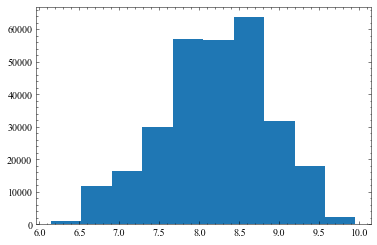

In [6]:
plt.hist(trData['AGE'])

Turning fluxes into magnitudes in Gaia: http://dc.zah.uni-heidelberg.de/tableinfo/gaia.dr2epochflux (useful vega mags)

In [7]:
def NewTablePhotErr(table):
    tab = table[:]#Make sure it's obvious these points aren't real!
    tab['SOURCE_ID']=np.zeros(len(table)).astype(np.int64)
    
    vegaMag = {'PHOT_G_MEAN_FLUX':25.6884, 'PHOT_BP_MEAN_FLUX':25.3514, 'PHOT_RP_MEAN_FLUX':24.7619} #magnitudes for these specific fluxes
    fluxCols = [('PHOT_G_MEAN_FLUX', 'PHOT_G_MEAN_FLUX_ERROR','PHOT_G_MEAN_MAG'), ('PHOT_BP_MEAN_FLUX', 'PHOT_BP_MEAN_FLUX_ERROR','PHOT_BP_MEAN_MAG'),
                ('PHOT_RP_MEAN_FLUX', 'PHOT_RP_MEAN_FLUX_ERROR','PHOT_RP_MEAN_MAG')]
    magCols = [('J_M', 'J_MSIGCOM'), ('H_M', 'H_MSIGCOM'), ('KS_M', 'KS_MSIGCOM'), ('W1MPRO', 'W1MPRO_ERROR'), ('W2MPRO', 'W2MPRO_ERROR')]
    
    np.warnings.filterwarnings('ignore')
    for flux, error, mag in fluxCols:
        F = np.array(tab[flux] + rn.normal(scale = tab[error]))
        tab.replace_column(flux, F)
        M = np.array(-2.5 * np.log10(tab[flux]) + vegaMag[flux])
        tab.replace_column(mag, M)

    for mag, error in magCols:
        M = np.array(tab[mag] + rn.normal(scale = tab[error]))
        tab.replace_column(mag, M)
    return tab

In [8]:
def NewTablePrlxErr(table):
    tab = table[:]#Make sure it's obvious these points aren't real!
    tab['SOURCE_ID']=np.zeros(len(table)).astype(np.int64)
    
    P = np.array(tab['PARALLAX'] + rn.normal(scale = tab['PARALLAX_ERROR']))
    tab.replace_column('PARALLAX', p)
    return tab

Extinction changes magnitudes by a predictable amount, so we can add extinction easily. However, note that this ruins the HR diagram curve, without correctly readding exctinction back in!

In [9]:
def NewTableAV(table, avMax = 10):
    tab = table[:]
    tab['SOURCE_ID']=np.zeros(len(table)).astype(np.int64)
    
    ext = {'J_M': 0.288,
     'H_M': 0.178,
     'KS_M': 0.117,
     'W1MPRO': 0.078,
     'W2MPRO': 0.044,
     'PHOT_G_MEAN_MAG': 0.859,
     'PHOT_BP_MEAN_MAG': 1.068,
     'PHOT_RP_MEAN_MAG': 0.652}
    
    moreAv = rn.rand(len(tab))*avMax
    for label in ext.keys():
        extinguished = tab[label]+moreAv * ext[label]
        tab.replace_column(label, extinguished)
        
    newAv = tab['AV']+moreAv
    tab.replace_column('AV', newAv)
    return tab

Changing parallax (distance) involves a shift in the distance modulus - magnitudes
$$m1 = 5\log(\frac{\pi_2}{\pi_1}) + M2$$

In [10]:
def NewTableParallax(table, min=.5, max=10): #up to 5 kpc, .2mas 
    tab = table[:]
    tab['SOURCE_ID']=np.zeros(len(table)).astype(np.int64)
    
    parallax = tab['PARALLAX']
    newParallax = rn.rand(len(tab))*(max-min)+min
    
    mags = ['J_M','H_M','KS_M','W1MPRO','W2MPRO','PHOT_G_MEAN_MAG','PHOT_BP_MEAN_MAG','PHOT_RP_MEAN_MAG']
    for label in mags:
        M = tab[label] + 5 * np.log10(parallax/newParallax)
        tab.replace_column(label, M)
        
    tab.replace_column('PARALLAX', newParallax)
    return tab

Now we can increase our sample size drastically

In [11]:
#Try number 3!
data = trData[:]
for i in range(2):
    eTab = NewTablePhotErr(trData)
    data = vstack([data, eTab])
for i in range(3):
    eTab = NewTablePhotErr(trData[np.where(trData['AGE']<7.5)[0]])
    data = vstack([data, eTab])
for i in range(3):
    prlxTab = NewTableParallax(trData)
    data = vstack([data, prlxTab])
prlxAge = NewTableParallax(trData[np.where(trData['AGE']<7.5)[0]])
data = vstack([data, prlxTab])
print(len(data))

C:\Python36\lib\site-packages\ipykernel_launcher.py:3: TableReplaceWarning: replaced column 'SOURCE_ID' which looks like an array slice. The new column no longer shares memory with the original array.
  This is separate from the ipykernel package so we can avoid doing imports until


2161264


In [13]:
np.random.seed(0); data[np.random.permutation(len(data))].write('Data/Train/f3_aug0.fits', overwrite = True)

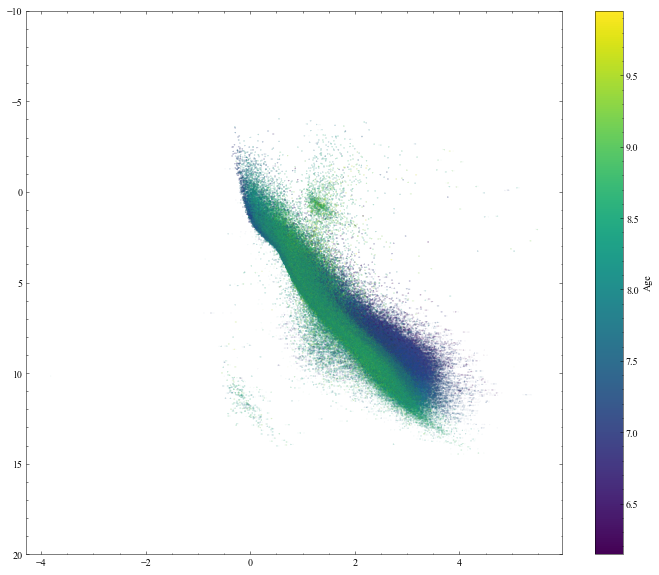

In [20]:
def absG(g, prlx):
    return np.array(g +5 - 5 * np.log10(1000/prlx))

G = absG(data['PHOT_G_MEAN_MAG'], data['PARALLAX'])
BPRP = data['PHOT_BP_MEAN_MAG']-data['PHOT_RP_MEAN_MAG']
age = np.array(data['AGE']).astype(np.float32)
ii = np.where(np.isnan(age)==False)[0]
fig, ax = plt.subplots(1,1, figsize = (12,10))
norm = colors.Normalize(vmin=np.nanmin(age), vmax=np.nanmax(age))
A=ax.scatter(BPRP[ii],G[ii],s=.0005, c=age[ii], norm = norm, cmap = 'viridis')
fig.colorbar(A, ax=ax, label = 'Age')
ax.set_ylim(20,-10)
plt.show()

In [ ]:
G = absG(data['PHOT_G_MEAN_MAG'], data['PARALLAX'])
BPRP = data['PHOT_BP_MEAN_MAG']-data['PHOT_RP_MEAN_MAG']
age = np.array(data['AGE']).astype(np.float32)
ii = np.where(np.isnan(age)==False)[0]
fig, ax = plt.subplots(1,1, figsize = (10,10))
norm = colors.Normalize(vmin=np.nanmin(age), vmax=np.nanmax(age))
A=ax.scatter(BPRP[ii],G[ii],s=.0005, c=age[ii], norm = norm, cmap = 'viridis')
fig.colorbar(A, ax=ax, label = 'Age')
ax.set_ylim(20,-10)
plt.show()

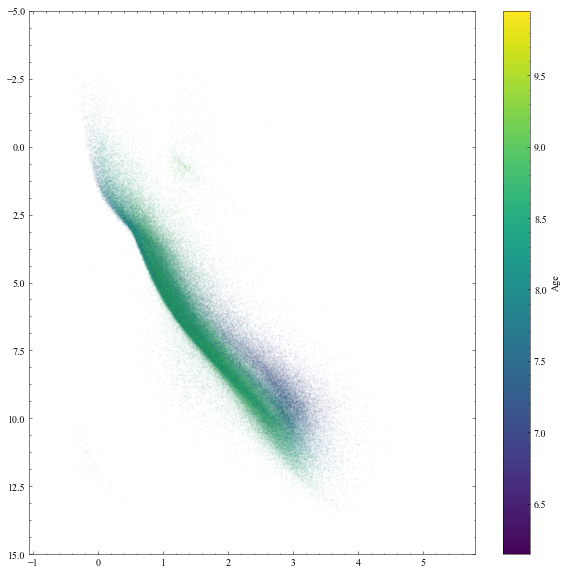

In [10]:
G = absG(trData['PHOT_G_MEAN_MAG'], trData['PARALLAX'])
BPRP = trData['PHOT_BP_MEAN_MAG']-trData['PHOT_RP_MEAN_MAG']
age = np.array(trData['AGE']).astype(np.float32)
ii = np.where(np.isnan(age)==False)[0]
fig, ax = plt.subplots(1,1, figsize = (10,10))
norm = colors.Normalize(vmin=np.nanmin(age), vmax=np.nanmax(age))
A=ax.scatter(BPRP[ii],G[ii],s=.0005, c=age[ii], norm = norm, cmap = 'viridis', alpha = 1)
fig.colorbar(A, ax=ax, label = 'Age')
ax.set_ylim(15,-5)
plt.show()

In [31]:
print(np.nanmin(convunit(trData['AV'], 'av')), np.nanmax(convunit(trData['AV'],'av')))
print(np.nanmin(convunit(data['AV'], 'av')), np.nanmax(convunit(data['AV'],'av')))

-0.30750212 -0.12500001
-0.3075021043419838 0.3583631648367001


In [17]:
def convunit(v,b,back=False):
    a=[['g',21,0.5],['bp',21,0.5],['rp',18,0.5],['j',17.5,0.5],['h',16.5,0.5],['k',16.5,0.5],
     ['w1',16.5,0.5],['w2',16.5,0.5],['w3',14,0.5],['parallax',20,0.5],['radius',5,0.54],
     ['logl',4,0],['av',20,0.3],['age',4,2],['mass',3,0.5],['teff',0.7,3.4/0.7+0.5],
     ['logg',2,2],['feh',3,-2.5/3+0.5]]
    for i in a:
        if b==i[0]:
            if back:
                return (v+i[2])*i[1]
            else:
                return (v/i[1])-i[2] 
            
def FitsToTensor(table):
    g = table['PHOT_G_MEAN_MAG'].astype(np.float32)
    x=np.where((g<19) & (np.nan_to_num(g)>0))[0]
    g=g[x].to_numpy()
    bp = table['PHOT_BP_MEAN_MAG'][x].astype(np.float32).to_numpy()
    rp = table['PHOT_RP_MEAN_MAG'][x].astype(np.float32).to_numpy()
    j = table['J_M'][x].astype(np.float32).to_numpy()
    h = table['H_M'][x].astype(np.float32).to_numpy()
    k = table['KS_M'][x].astype(np.float32).to_numpy()
    w1 = table['W1MPRO'][x].astype(np.float32).to_numpy()
    w2 = table['W2MPRO'][x].astype(np.float32).to_numpy()
    w3 = table['W3MPRO'][x].astype(np.float32).to_numpy() #ignore for the most part
    parallax = table['PARALLAX'][x].astype(np.float32).to_numpy()
    logl = np.log10(table['lum_val'][x].astype(np.float32).to_numpy())
    radius = table['radius_val'][x].astype(np.float32).to_numpy()

    # teff = table['teff_val'][x].astype(np.float32).to_numpy() #TOO MANY NaN
    av = table['AV'][x].astype(np.float32).to_numpy()
    age = table['AGE'][x].astype(np.float32).to_numpy()

    np.warnings.filterwarnings('ignore')
    bp[np.where((bp>20.5)|(np.isnan(bp)))[0]]=21
    rp[np.where((rp>17.5)|(np.isnan(rp)))[0]]=18
    j[np.where((j>17)|(np.isnan(j)))[0]]=17.5
    h[np.where((h>16)|(np.isnan(h)))[0]]=16.5
    k[np.where((k>16)|(np.isnan(k)))[0]]=16.5
    w1[np.where((w1>16)|(np.isnan(w1)))[0]]=16.5
    w2[np.where((w2>16)|(np.isnan(w2)))[0]]=16.5
    w3[np.where((w3>13.5)|(np.isnan(w3)))[0]]=14
    radius[np.where((radius<0.5)|(np.isnan(radius)))[0]]=0.5
    logl[np.where((logl<-1.54)|(np.isnan(logl)))[0]]=-1.54

    s0 = np.arange(0,int(len(x)*.6))
#     print(len(s0))
    s1 = np.arange(int(len(x)*.6), int(len(x)*.8))
    s2 = np.arange(int(len(x)*.8),len(x)) 

    length = [len(s0), len(s1), len(s2)]
    sample = [s0, s1, s2]

    for i in range(3):
        clx = Tensor(length[i], 1, 11)*0-0.5
        cly = Tensor(length[i], 2)*0-0.5
        c = sample[i]

        clx[:,0,0]= Tensor(convunit(g[c], 'g'))
        clx[:,0,1]= Tensor(convunit(bp[c], 'bp'))
        clx[:,0,2]= Tensor(convunit(rp[c], 'rp'))
        clx[:,0,3]= Tensor(convunit(j[c], 'j'))
        clx[:,0,4]= Tensor(convunit(h[c], 'h'))
        clx[:,0,5]= Tensor(convunit(k[c], 'k'))
        clx[:,0,6]= Tensor(convunit(w1[c], 'w1'))
        clx[:,0,7]= Tensor(convunit(w2[c], 'w2'))
    #     clx[:,0,8]= Tensor(convunit(w3[c], 'w3'))
        clx[:,0,8]= Tensor(convunit(parallax[c], 'parallax'))
        clx[:,0,9]= Tensor(convunit(logl[c], 'logl'))
        clx[:,0,10]= Tensor(convunit(radius[c], 'radius'))
        cly[:,0]= Tensor(convunit(age[c], 'age'))
        cly[:,1]= Tensor(convunit(av[c], 'av'))
        pickle.dump([clx, cly], open('data/train/augtensors/f3aug'+str(i)+'.pickle', 'wb'))

In [18]:
FitsToTensor(data.to_pandas())

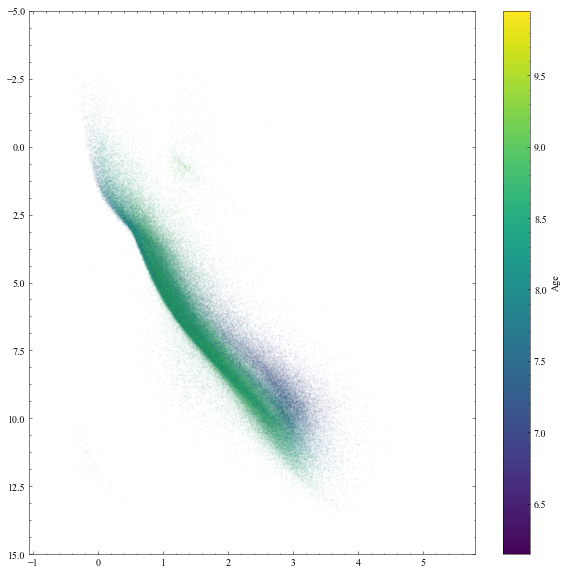

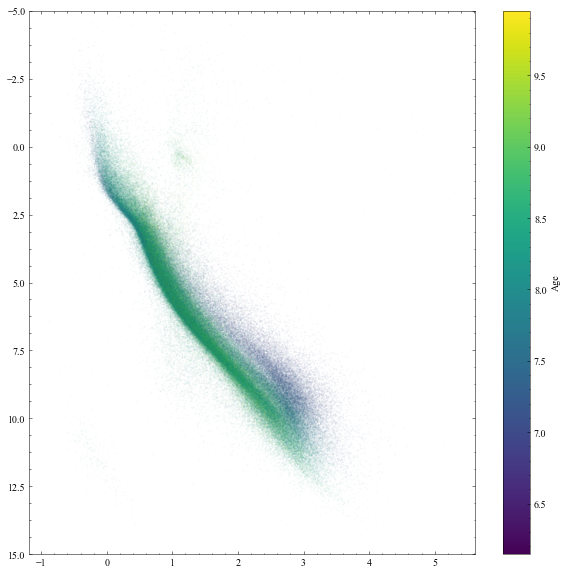

In [39]:
def extinct(table, bands = None, back = False, fullTab = False):
    tab = table[:]
    ext = {'J_M': 0.288,
        'H_M': 0.178,
        'KS_M': 0.117,
        'W1MPRO': 0.078,
        'W2MPRO': 0.044,
        'PHOT_G_MEAN_MAG': 0.859,
        'PHOT_BP_MEAN_MAG': 1.068,
        'PHOT_RP_MEAN_MAG': 0.652}
    if bands==None:
        bands = list(ext.keys())
        
    for label in bands:
        if back == True:
            tab[label]=tab[label]-tab['AV']*ext[label]
        else:
            tab[label]=tab[label]+tab['AV']*ext[label]
            
    if fullTab=True:
        return tab
    return tab[bands]

G = absG(trData['PHOT_G_MEAN_MAG'], trData['PARALLAX'])
BPRP = trData['PHOT_BP_MEAN_MAG']-trData['PHOT_RP_MEAN_MAG']
age = np.array(trData['AGE']).astype(np.float32)
ii = np.where(np.isnan(age)==False)[0]
fig, ax = plt.subplots(1,1, figsize = (10,10))
norm = colors.Normalize(vmin=np.nanmin(age), vmax=np.nanmax(age))
A=ax.scatter(BPRP[ii],G[ii],s=.0005, c=age[ii], norm = norm, cmap = 'viridis', alpha = 1)
fig.colorbar(A, ax=ax, label = 'Age')
ax.set_ylim(15,-5)
plt.show()

unext = extinct(trData, back = True)
G = absG(unext['PHOT_G_MEAN_MAG'], trData['PARALLAX'])
BPRP = unext['PHOT_BP_MEAN_MAG']-unext['PHOT_RP_MEAN_MAG']
age = np.array(trData['AGE']).astype(np.float32)
ii = np.where(np.isnan(age)==False)[0]
fig, ax = plt.subplots(1,1, figsize = (10,10))
norm = colors.Normalize(vmin=np.nanmin(age), vmax=np.nanmax(age))
A=ax.scatter(BPRP[ii],G[ii],s=.0005, c=age[ii], norm = norm, cmap = 'viridis', alpha = 1)
fig.colorbar(A, ax=ax, label = 'Age')
ax.set_ylim(15,-5)
plt.show()